# Macrogenesismodel

## Table of contens

1. preparation of XML files by parsing and collecting specific elements
2. relation-element graphs<br>
    2.1. graph for tempsyn relation-elements<br>
    2.2. graph for temppre relation-elements
3. ...
4. ...
...
TODO

In [1]:
from faust_macrogen_graph import parserutils, analyzeutils, absolute_graphutils, relative_graphutils, eades_fas
from pathlib import Path
import pandas as pd
from collections import Counter, OrderedDict
import networkx as nx
import matplotlib.pyplot as plt

## 1. preparation of XML files by parsing and collecting specific elements

In [89]:
filespath = Path('resources')
temppre_items = parserutils.xmlparser(filespath)
tempsyn_items = parserutils.xmlparser(filespath, False, False)
date_items = parserutils.xmlparser(filespath, True)

## 2. relation-element graphs

TODO<br>
explain everything (introduction)<br>
using eades (baharev?)<br>
what is the goal?<br>
how we proceed?<br>

### 2.1. graph for tempsyn relation-elements

First we create a graph only based of the relation-elements with the @tempsyn-attribute. We use this graph later for adding it with the graph based on the relation-elements with the @temppre-attribute and the date-elements. 

In [92]:
tempsynG = nx.DiGraph()
for t in tempsyn_items:
    relative_graphutils.add_egdes_from_node_list(tempsynG, t)


We check if the removal of a computed FAS makes the graph acyclic. 

In [100]:
if nx.is_directed_acyclic_graph(tempsynG) == True:
    print("The tempsyn graph is acyclic!")
else:
    tempsynG_fas = eades_fas.eades_FAS(tempsynG, True)

    #atempysnG = acyclic tempsyn Graph
    atempsynG = tempsynG.copy()
    atempsynG.remove_edges_from(tempsynG_fas)
    if nx.is_directed_acyclic_graph(atempsynG) == True:
        print("The tempsyn graph without the FAS (" + str(len(tempsynG_fas)) + " edges) is acyclic!")

The tempsyn graph without the FAS (8) is acyclic!


### 2.2. graph for temppre relation-elements 

Same approach as with the @tempsyn-relation-elements (see 2.1).

In [95]:
temppreG = nx.DiGraph()
for t in temppre_items:
    relative_graphutils.add_egdes_from_node_list(temppreG, t)

In [101]:
if nx.is_directed_acyclic_graph(temppreG) == True:
    print("The temppre graph is acyclic!")
else:
    temppreG_fas = eades_fas.eades_FAS(temppreG, True)
    #atemppreG = acyclic temppre Graph
    atemppreG = temppreG.copy()
    atemppreG.remove_edges_from(temppreG_fas)
    if nx.is_directed_acyclic_graph(atemppreG) == True:
        print("The temppre graph without the FAS (" + str(len(temppreG_fas)) + " edges) is acyclic!")

The temppre graph without the FAS (68 edges) is acyclic!


## 3. date-element graph & the whole graph

We got for the creation of the date graph several approaches of which three doesn't induce a FAS. As shown by the DataFrame <b>dgadf</b> (= date graphs approaches DataFrame), only the approach of <b>Vitt</b> induces a FAS by itself. The reason behind this is that the other approaches are not designed to work by themselves.

In [110]:
approaches = ["vitt", "wissenbach", "paulus-1", "paulus-2"]

approaches_graphs = {}
approaches_fas =  {}

for approach in approaches:
    datesG = absolute_graphutils.graph_from_dates(date_items, approach)
    approaches_graphs[approach] = datesG
    datesG_fas = eades_fas.eades_FAS(datesG, True)
    #adatesG = acyclic dates graph
    adatesG = datesG.copy()
    adatesG.remove_edges_from(datesG_fas)
    
    
    approaches_fas[approach] = datesG_fas

date_graphs_approaches = {}
columns = ["n nodes", "n edges", "n cycles", "n feedback edges"]

for k, v in approaches_graphs.items():
    #if k in approaches_fas:
    date_graphs_approaches[k] = [len(v.nodes()), len(v.edges()), len(list(nx.simple_cycles(v))), len(approaches_fas[k])]

dgadf = pd.DataFrame(date_graphs_approaches)#, columns=columns)
dgadf = dgadf.T
dgadf.columns = columns
dgadf

,n nodes,n edges,n cycles,n feedback edges
vitt,723,679,19,19
wissenbach,681,437,0,0
paulus-1,649,437,0,0
paulus-2,642,437,0,0


TODO<br>
For a more meaningful comparison between the approaches we have to create a graph ot of the tempsyn-, temppre- and date-graphs which will in the end represent the desired graph on which we will work on.

In [112]:
approaches = ["vitt", "wissenbach", "paulus-1", "paulus-2"]

approaches_graphs = {}
approaches_fas =  {}


tmpG = nx.compose(temppreG, tempsynG)

for approach in approaches:
    datesG = absolute_graphutils.graph_from_dates(date_items, approach)
    G = nx.compose(tmpG, datesG)
    
    approaches_graphs[approach] = G
    G_fas = eades_fas.eades_FAS(G, True)
    #adatesG = acyclic dates graph
    aG = G.copy()
    aG.remove_edges_from(G_fas)

    approaches_fas[approach] = G_fas

graphs_approaches = {}
columns = ["n nodes", "n edges", "n cycles", "n feedback edges"]

for k, v in approaches_graphs.items():
    #if k in approaches_fas:
    graphs_approaches[k] = [len(v.nodes()), len(v.edges()), len(list(nx.simple_cycles(v))), len(approaches_fas[k])]

dgadf = pd.DataFrame(graphs_approaches)#, columns=columns)
dgadf = dgadf.T
dgadf.columns = columns
dgadf

,n nodes,n edges,n cycles,n feedback edges
vitt,964,1669,1766,135
wissenbach,922,1427,532,79
paulus-1,890,1427,532,79
paulus-2,883,1427,532,79


TODO. more approaches? explain approaches?<br>
The new comparison shows that the <b>Vitt</b>-approach superior to the other approaches. From now one we will take the Vitt-approach to represent the date-elements within the graph. 

In [117]:
datesG = absolute_graphutils.graph_from_dates(date_items, "vitt")
G = nx.compose(tmpG, datesG)
G_fas = eades_fas.eades_FAS(G, True)
aG = G.copy()
aG.remove_edges_from(G_fas)
if nx.is_directed_acyclic_graph(aG) == True:
    print("The dates graph is acyclic!")

The dates graph is acyclic!


In [119]:
len(G.edges())

1669

## 4. Analyzation 

The FAS for the whole Graph contains 135 edges. The whole graph G contains 1669 edges, so 8% of all edges are in the FAS. This percentage is too high and several solution approaches should be tried out to reduce the percentage.

In [120]:
print(str(int((len(G_fas) / len(G.edges())) * 100)) + "% of all edges of G are in the FAS.")

8% of all edges of G are in the FAS.


### 4.1 Rank sources by normed witness scores

In this chapter we take a look at the source attributes of the edges. In the XML files, a dating is attested by a source. The problem is that these sources contradict each other which is certainly the reason for the existance of a FAS. The make the graph acyclic, we have to get rid of these contradictory statements.<br>
We parse through the "source"-attributes of the edges of the graph and return a Counter with a frequency score assigned to each researcher. The idea behind this is that a researcher who contributed more than others will get a much higher score. The problem is that by this method quantity surpasses quality. It is not that simple to compare two academic works by its quality and the resulting benefit for the research because the comparison possibilities are manifold and a detailed comparison would exceed this work. As simplification we adjust the scores by multiplying each score with a normalized year of the publication of the researches work about <b>Faust</b>.

<u>An example</u>: <br>
Anne Bohnenkamp released her work „… das Hauptgeschäft nicht außer Augen lassend“ 1994. Her work is used as source 355 times in the Faustedition. After the "Weimarer Ausgabe, Abt. I, Bd. 15,2, Weimar 1888 (wa_I_15_2) she is the most named source for datings. 

min_range: 1770 (Goethe began to work on his "Urfaust" 1770) <br>
max_range: 2017 (According to http://www.faustedition.net/bibliography, the youngest considered work about Faust beside the Faustedition is <b>Brüning / Hahn 2017</b>.)

Bohnenkamp 1994: 355 * ((1994 - 1770) / (2017 - 1770)) = 321.9433198380567

After the normalization Bohnenkamp surpasses the "wa_I_15_2". We simply assume in this work that datings of newer works are better and more accurately than older works. One of the reasonings behind this is that newer works are able to make their statements against the background of older researchs, while the older researchs are unable to do so.

TODO: MORE? what do with the normalized score?

In [122]:
research_scores = analyzeutils.get_research_score(G)
sorted_research_scores = {k: research_scores[k] 
                              for k in sorted(research_scores, key=research_scores.get, reverse=True)}

norm_research_scores = analyzeutils.get_norm_research_score(G, 1770, 2020)
sorted_norm_research_scores = {k: norm_research_scores[k]
                              for k in sorted(norm_research_scores, key=norm_research_scores.get, reverse=True)}

research_df = pd.DataFrame(sorted_research_scores.items(), columns=["source", "year_frequency"])
research_df.set_index("source", inplace=True)
norm_research_df = pd.DataFrame(sorted_norm_research_scores.items(), columns=["source", "norm_year_frequency"])
norm_research_df.set_index("source", inplace=True)
ndf = research_df.join(norm_research_df)
ndf

,year_frequency,norm_year_frequency
source,,
faust://bibliography/wa_I_15_2,449,211.928
faust://bibliography/bohnenkamp1994,355,318.080
faust://bibliography/fischer-lamberg1955,346,256.040
faust://bibliography/landeck1981,141,119.004
faust://self,138,126.960
faust://bibliography/hertz1932,73,47.304
faust://bibliography/gsa-datenbank,27,19.440
faust://bibliography/inventare_2_2,26,25.064
faust://bibliography/hertz1931,10,6.440


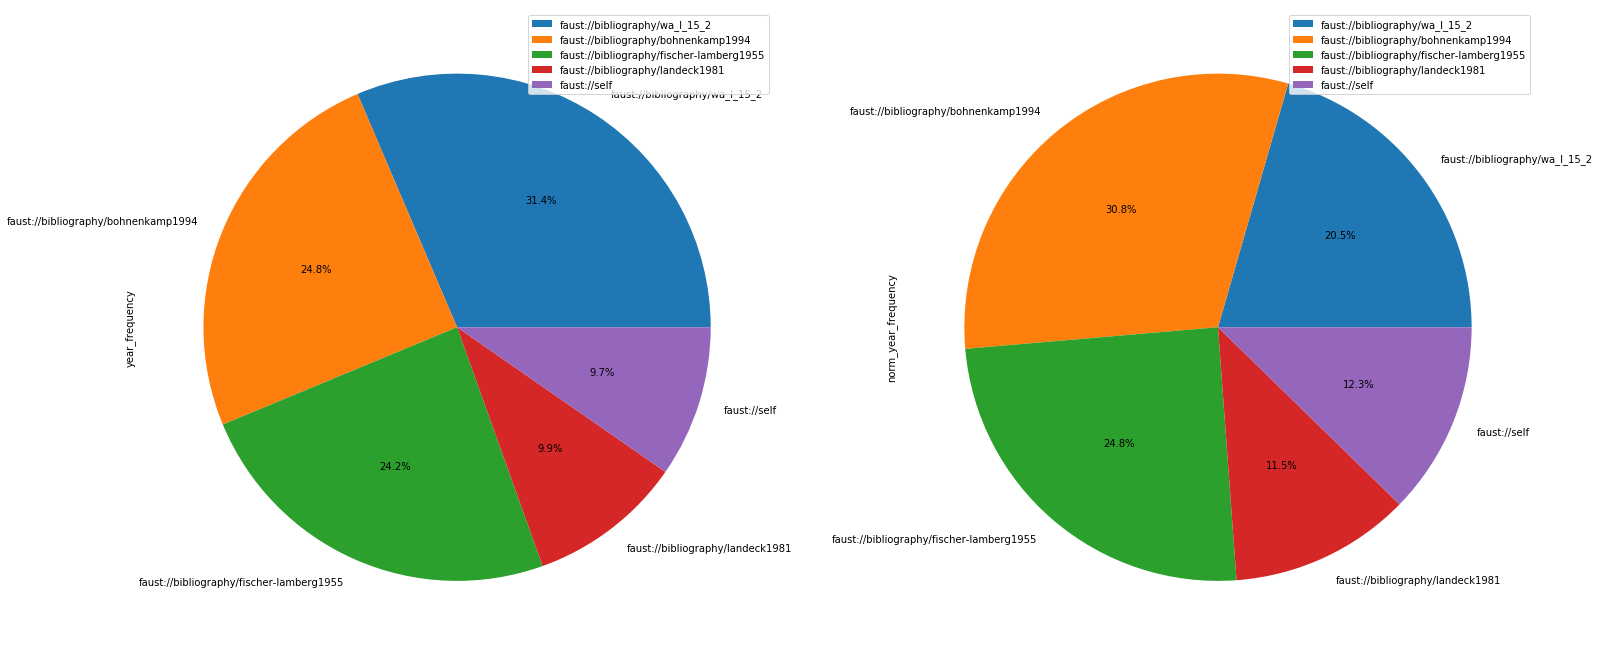

In [123]:
plot = ndf[:5].plot.pie(subplots=True, figsize=(25,25), autopct='%.1f%%')
plt.show()

### 4.2 Removing nodes and edges by critical sources

After the normalization of the source count we have a deeper look at the <b>Feedback Arc Set</b>. The FAS contains 135 edges. More than a third of the FAS is taken up by "wa_I_15_2" and more than twice as much as the second, third and fourth most common sources "fischer-lamberg1955", "bohnenkamp1994" and "landeck1981".

TODO: more!

TODO: goal making Graph acyclic by not FAS but removing entire sources (Analyse nach Quellen!!)


In [23]:
fas_source_counter = Counter()
for edge in G_fas:
    if G.has_edge(edge[0], edge[1]):
        edge_data = G.get_edge_data(edge[0], edge[1])
        key = edge_data["source"]
        if fas_source_counter[key]:
            fas_source_counter[key] += 1
        else:
            fas_source_counter[key] = 1

cdf = pd.DataFrame.from_dict(OrderedDict(fas_source_counter.most_common()), orient="index").reset_index()
cdf = cdf.rename(columns={"index":"source", 0:"fas_frequency"})
cdf.set_index("source", inplace=True)
cdf

,fas_frequency
source,
faust://bibliography/wa_I_15_2,41
faust://bibliography/fischer-lamberg1955,16
faust://bibliography/landeck1981,7
faust://bibliography/hertz1932,6
faust://bibliography/bohnenkamp1994,5
faust://self,3
faust://bibliography/inventare_2_2,1


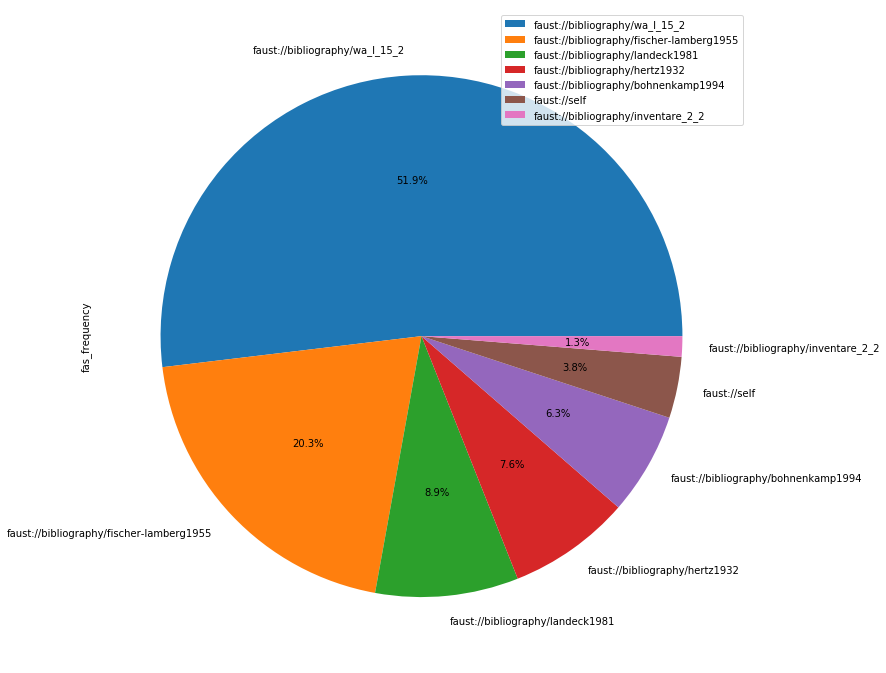

In [24]:
plot = cdf.plot.pie(y="fas_frequency", figsize=(12, 12), autopct='%.1f%%')
plt.show()

In [25]:
df = ndf.join(cdf)
df = df.dropna()
df

,year_frequency,norm_year_frequency,fas_frequency
source,,,
faust://bibliography/wa_I_15_2,447,210.984,41.0
faust://bibliography/fischer-lamberg1955,296,219.040,16.0
faust://bibliography/bohnenkamp1994,278,249.088,5.0
faust://bibliography/landeck1981,128,108.032,7.0
faust://self,118,108.560,3.0
faust://bibliography/hertz1932,41,26.568,6.0
faust://bibliography/inventare_2_2,39,37.596,1.0


We now generate a Dataframe where the sources of the FAS edges determine the index and the 
- frequency of the researcher as manuscript source
- normed frequency of the researcher as manuscript source
- frequency of the researcher as source of an edge in the FAS
- percentage which determines how many edges of an researcher are in the FAS
- percentage which determines how many edges of an researcher (based on the normalized year frequency) are in the FAS

determine the four columns.
TODO

In [26]:
percent_fas = (df["fas_frequency"] / df["year_frequency"]) * 100
norm_percent_fas = (df["fas_frequency"] / df["norm_year_frequency"]) * 100
pcdf = pd.concat([percent_fas, norm_percent_fas], axis=1, sort=True)
#pcdf = percent_fas.to_frame()
pcdf = pcdf.rename(columns={0:"percent_fas", 1:"norm_percent_fas"})
pcdf.sort_values(by="percent_fas", ascending=False)
df = df.join(pcdf, on="source")
df
#Note: If the following Error raises, restart the code cell before this one and it should work
#ValueError: columns overlap but no suffix specified: Index(['percent_fas', 'norm_percent_fas'], dtype='object')

,year_frequency,norm_year_frequency,fas_frequency,percent_fas,norm_percent_fas
source,,,,,
faust://bibliography/wa_I_15_2,447,210.984,41.0,9.172260,19.432753
faust://bibliography/fischer-lamberg1955,296,219.040,16.0,5.405405,7.304602
faust://bibliography/bohnenkamp1994,278,249.088,5.0,1.798561,2.007323
faust://bibliography/landeck1981,128,108.032,7.0,5.468750,6.479562
faust://self,118,108.560,3.0,2.542373,2.763449
faust://bibliography/hertz1932,41,26.568,6.0,14.634146,22.583559
faust://bibliography/inventare_2_2,39,37.596,1.0,2.564103,2.659857


For answering the question which complete source we want to remove to make the Graph acyclic without computing a FAS, we rely on several characteristics a source should have to be rather removed from the Graph than other sources:
1. Very old source 
2. small of amount of edges in the Graph
3. resulting from (1) and (2) a high <b>norm_percent_fas</b>-score.
4. ?

If a source meets many of the mentioned characteristics, we remove every edge with the source as attribute and compare how much the FAS shrinkes afterwards.


In [27]:
critical_sources = {}
param = 1
for k, v in dict(df["norm_percent_fas"]).items():
    if v >= param:
        critical_sources[k] = v
critical_sources = [(k, critical_sources[k]) for k in sorted(critical_sources, key=critical_sources.get, reverse=True)]        
critical_sources

[('faust://bibliography/hertz1932', 22.58355916892502),
 ('faust://bibliography/wa_I_15_2', 19.432753194555037),
 ('faust://bibliography/fischer-lamberg1955', 7.304601899196495),
 ('faust://bibliography/landeck1981', 6.479561611374408),
 ('faust://self', 2.763448784082535),
 ('faust://bibliography/inventare_2_2', 2.6598574316416643),
 ('faust://bibliography/bohnenkamp1994', 2.007322713257965)]

In [28]:

critical_sources_fas = {}
for critical_source in critical_sources:
    F = G.copy()
    for edge in list(F.edges()):
        edge_data = F.get_edge_data(edge[0], edge[1])
        if edge_data["source"] == critical_source[0]:
            F.remove_edge(edge[0], edge[1])
    F_fas = eades_fas.eades_FAS(F, True)
    critical_sources_fas[critical_source[0]] = len(F_fas)
critical_sources_fas

{'faust://bibliography/hertz1932': 70,
 'faust://bibliography/wa_I_15_2': 22,
 'faust://bibliography/fischer-lamberg1955': 53,
 'faust://bibliography/landeck1981': 68,
 'faust://self': 80,
 'faust://bibliography/inventare_2_2': 78,
 'faust://bibliography/bohnenkamp1994': 70}

In [29]:
criticals = pd.Series(critical_sources_fas)
criticals = criticals.to_frame()
ndf = df.join(criticals)
ndf.rename(columns={0:"fas_without_source"}, inplace=True)
ndf

#Note: If the following Error raises, restart the code cell with the creation of "df" and it should work
#ValueError: columns overlap but no suffix specified: Index(['percent_fas', 'norm_percent_fas'], dtype='object')

,year_frequency,norm_year_frequency,fas_frequency,percent_fas,norm_percent_fas,fas_without_source
source,,,,,,
faust://bibliography/wa_I_15_2,447,210.984,41.0,9.172260,19.432753,22
faust://bibliography/fischer-lamberg1955,296,219.040,16.0,5.405405,7.304602,53
faust://bibliography/bohnenkamp1994,278,249.088,5.0,1.798561,2.007323,70
faust://bibliography/landeck1981,128,108.032,7.0,5.468750,6.479562,68
faust://self,118,108.560,3.0,2.542373,2.763449,80
faust://bibliography/hertz1932,41,26.568,6.0,14.634146,22.583559,70
faust://bibliography/inventare_2_2,39,37.596,1.0,2.564103,2.659857,78


comparison of FAS when every source will be removed from G

In [30]:
scores = dict(analyzeutils.get_research_score(G))

critical_sources_fas = {}
for score in scores:
    F = G.copy()
    for edge in list(F.edges()):
        edge_data = F.get_edge_data(edge[0], edge[1])
        if edge_data["source"] == score:
            F.remove_edge(edge[0], edge[1])
    F_fas = eades_fas.eades_FAS(F, True)
    critical_sources_fas[score] = len(F_fas)
critical_sources_fas = [(k, critical_sources_fas[k]) for k in sorted(critical_sources_fas, key=critical_sources_fas.get, reverse=True)]
possible_critical_sources = {}
for t in critical_sources_fas:
    if t[0] not in list(ndf.index.values) and t[1] != 135:
        possible_critical_sources[t[0]] = t[1]
possible_critical_sources

{'faust://bibliography/scheibe1965': 79,
 'faust://bibliography/graef1901-1914_II_2': 79,
 'faust://bibliography/schillemeit1985': 79,
 'faust://bibliography/hertz1931': 79,
 'faust://bibliography/pniower1899': 79,
 'faust://bibliography/bluhm1966': 79,
 'faust://bibliography/duentzer1891b': 79,
 'faust://bibliography/morris1902b': 79,
 'faust://bibliography/grumach1953': 79,
 'faust://bibliography/witkowski1894': 79,
 'faust://bibliography/wa_I_14': 79,
 'faust://bibliography/pravida2015': 79,
 'faust://bibliography/suphan1876': 79,
 'faust://bibliography/krogmann1933': 79,
 'faust://bibliography/harnack1891': 79,
 'faust://bibliography/morris1899': 79,
 'faust://bibliography/schillemeit1986': 79,
 'faust://bibliography/bruening_hahn2017': 79,
 'faust://bibliography/mmommsen1953': 79,
 'faust://bibliography/wa_I_53': 79,
 'faust://bibliography/frankenberger1926': 79,
 'faust://bibliography/scheibe1974': 79,
 'faust://bibliography/lohmeyer1927': 79,
 'faust://bibliography/aa_duw_2': 79